In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import random
from datasets import Dataset
from datasets import load_metric
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [2]:
df = pd.read_csv("/media/zhoujieli/T5 EVO/multimer_esm_project/df_merged.csv")

In [3]:
df.head()

,sequence,sym
0,MIIELDEFTRVEGNGKAEIVIENGEVKDARVKIVEGPRFFEILTLG...,0
1,MDNNLTSKLKYREAKLGYLMILPLLTVVLVFIILPVMGTFWISLHR...,1
2,MEEVTQVRKRRPAIEKKIAEITENDTRVSIIGKVIKVDKMEYLFWL...,0
3,MGKFVEKLENAIRGYTFDDVLLIPQPTEVEPKDVDVSTQITPNVKL...,2
4,MISETIRSGDWKGEKHVPVIEYEREGELVKVKVQVGKEIPHPNTTE...,1


In [4]:
df.sym.value_counts()

sym
0    25571
1     7157
2     1025
Name: count, dtype: int64

In [5]:
sequences = df.sequence.to_list()
labels = df.sym.to_list()

# # Quick check to make sure we got it right
len(sequences) == len(labels)
indices = np.arange(len(sequences))

In [6]:
train_sequences, test_sequences, train_labels, test_labels, indices_train, indices_test= train_test_split(sequences, labels, indices, test_size=0.25, shuffle=True)

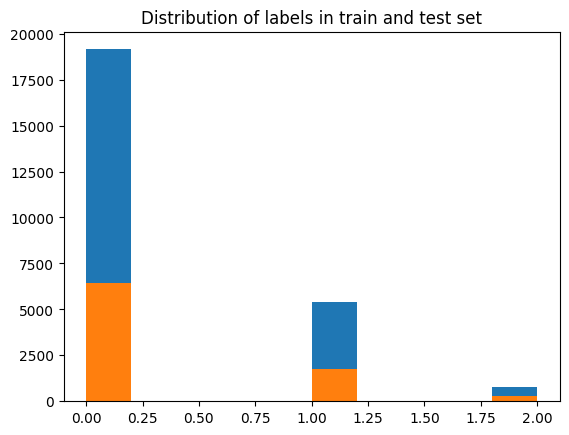

In [7]:
plt.hist(train_labels)
plt.hist(test_labels)
plt.title('Distribution of labels in train and test set')
plt.show()

In [8]:
# model_checkpoint = "facebook/esm2_t36_3B_UR50D"
# model_checkpoint = "facebook/esm2_t33_650M_UR50D"
# model_checkpoint = "facebook/esm2_t30_150M_UR50D"
model_checkpoint = "facebook/esm2_t12_35M_UR50D"
# model_checkpoint = "facebook/esm2_t6_8M_UR50D"

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [10]:
tokenizer(train_sequences[random.randint(0, len(train_sequences))])

{'input_ids': [0, 20, 17, 9, 4, 12, 17, 8, 17, 5, 12, 15, 20, 11, 8, 12, 9, 12, 5, 9, 4, 7, 6, 8, 10, 21, 13, 15, 7, 15, 16, 8, 12, 9, 10, 4, 5, 7, 10, 6, 7, 12, 10, 17, 14, 14, 20, 7, 7, 18, 9, 15, 12, 17, 17, 4, 6, 4, 4, 10, 6, 7, 9, 5, 19, 7, 18, 9, 6, 9, 16, 6, 15, 10, 13, 8, 12, 12, 7, 7, 5, 16, 4, 8, 14, 9, 18, 11, 5, 10, 4, 7, 13, 10, 22, 10, 9, 4, 9, 6, 5, 11, 5, 15, 12, 14, 16, 11, 18, 8, 9, 5, 4, 10, 4, 5, 5, 13, 4, 9, 13, 16, 15, 5, 9, 4, 9, 15, 16, 4, 5, 4, 5, 5, 14, 15, 7, 9, 18, 5, 13, 10, 7, 6, 9, 5, 8, 6, 12, 4, 12, 6, 17, 18, 5, 15, 7, 7, 6, 12, 6, 14, 17, 15, 4, 18, 5, 22, 20, 10, 13, 21, 15, 12, 4, 12, 5, 8, 6, 8, 10, 10, 17, 7, 14, 20, 16, 9, 19, 20, 13, 10, 6, 19, 18, 11, 7, 15, 9, 11, 5, 7, 17, 11, 17, 21, 6, 12, 16, 12, 8, 18, 11, 11, 15, 12, 11, 6, 10, 6, 16, 16, 22, 4, 11, 10, 15, 4, 4, 13, 17, 6, 20, 4, 15, 7, 11, 10, 9, 5, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [11]:
train_tokenized = tokenizer(train_sequences, truncation=True, max_length=1024)
test_tokenized = tokenizer(test_sequences, truncation=True, max_length=1024)

In [12]:
train_dataset = Dataset.from_dict(train_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)
train_dataset = train_dataset.add_column("labels", train_labels)
test_dataset = test_dataset.add_column("labels", test_labels)
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 25314
})

In [13]:
test_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 8439
})

In [14]:
num_labels = max(train_labels + test_labels) + 1  # Add 1 since 0 can be a label
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
num_labels

3

In [16]:
model_name = model_checkpoint.split("/")[-1]
batch_size = 12

args = TrainingArguments(
    f"{model_name}-35M-feb24",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="recall",
    push_to_hub=False,
)

In [17]:
metric = load_metric("recall")
# metric = load_metric("accuracy.py")
# metric = load_metric("roc_auc.py")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

/tmp/ipykernel_25408/719320891.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("recall")
/home/ps/miniconda3/envs/protein/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for recall contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/recall/recall.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
Using the latest cached version of the module from /home/zhoujieli/.cache/huggingface/modules/datasets_modules/metrics/recall/7a9906327e9cd2831a4c312e12856ea404bbaacb2032a3c61ce62a7b0f7

In [18]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [19]:
trainer.train()

/home/ps/miniconda3/envs/protein/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Recall
1,0.446800,0.400069,0.853774
2,0.341100,0.380183,0.866216
3,0.237200,0.401648,0.862187
4,0.158500,0.459827,0.865742
5,0.100100,0.599570,0.871075
6,0.053100,0.701217,0.857092
7,0.027300,0.778322,0.863135
8,0.017300,0.821919,0.870719
9,0.009500,0.876442,0.870719
10,0.005400,0.879492,0.869534


/home/ps/miniconda3/envs/protein/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ps/miniconda3/envs/protein/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ps/miniconda3/envs/protein/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ps/miniconda3/envs/protein/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: W

TrainOutput(global_step=10550, training_loss=0.14416014119347126, metrics={'train_runtime': 7135.9417, 'train_samples_per_second': 35.474, 'train_steps_per_second': 1.478, 'total_flos': 5.124605336112125e+16, 'train_loss': 0.14416014119347126, 'epoch': 10.0})

In [22]:
len(indices_train), len(indices_test)

(25314, 8439)

In [25]:
df["sequence"][indices_train[123]] == train_sequences[123]

True

In [26]:
# expand the df by two columns, train and test, if the sequence is in the train or test set
df["train"] = False
df["test"] = False
df["train"][indices_train] = True
df["test"][indices_test] = True


/tmp/ipykernel_25408/2070880872.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["train"][indices_train] = True
/tmp/ipykernel_25408/2070880872.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["test"][indices_test] = True


In [28]:
df.to_csv("/media/zhoujieli/T5 EVO/multimer_esm_project/df_merged_train_test.csv", index=False)